# Part IV: Sentiment analysis using LSTM [20 points]
In this part, we perform a sentiment analysis using LSTM model. The final (improved) model should achieve a test accuracy of greater than 75%.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import time
import torch
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from torchtext.vocab import build_vocab_from_iterator
import torch.nn as nn
import torchinfo
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_recall_fscore_support
import time
import random
import torch.nn as nn
from sklearn.metrics import confusion_matrix, classification_report
from torchtext.data.utils import get_tokenizer

## Step 1: Data exploration and preprocessing

1. Load your chosen dataset and print the main statistics

In [ ]:
### ADD YOUR CODE HERE ###
file_path = "Tweets.csv"
df = pd.read_csv(file_path)
df.info(), df.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

(None,
             tweet_id airline_sentiment  airline_sentiment_confidence  \
 count   1.464000e+04             14640                  14640.000000   
 unique           NaN                 3                           NaN   
 top              NaN          negative                           NaN   
 freq             NaN              9178                           NaN   
 mean    5.692184e+17               NaN                      0.900169   
 std     7.791112e+14               NaN                      0.162830   
 min     5.675883e+17               NaN                      0.335000   
 25%     5.685592e+17               NaN                      0.692300   
 50%     5.694779e+17               NaN                      1.000000   
 75%     5.698905e+17               NaN                      1.000000   
 max     5.703106e+17               NaN                      1.000000   
 
                 negativereason  negativereason_confidence airline  \
 count                     9178              

2. Print the first 5 rows of the dataset to understand its structure

In [ ]:
### ADD YOUR CODE HERE ###

df.head(5)


tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)

3. Provide a brief description of the dataset

<span style='color:green'>### YOUR ANSWER ###</span>

4. Display descriptive statistics

Already given in visualisation below


In [ ]:
### ADD YOUR CODE HERE ###
print("\nDescriptive Statistics (Numeric Columns):")
print(df.describe())

# Print descriptive statistics for categorical (object) columns
print("\nDescriptive Statistics (Categorical Columns):")
print(df.describe(include=['O']))
# Optional: Print descriptive statistics for all columns
print("\nDescriptive Statistics (All Columns):")
print(df.describe(include='all'))

# Optional: Show the first few rows to get an idea of the data structure
print("\nFirst 5 Rows of the DataFrame:")
print(df.head())

# Optional: Print missing values count per column
print("\nMissing Values per Column:")
print(df.isnull().sum())


Descriptive Statistics (Numeric Columns):
           tweet_id  airline_sentiment_confidence  negativereason_confidence  \
count  1.460400e+04                  14604.000000               10503.000000   
mean   5.692157e+17                      0.899923                   0.637644   
std    7.782567e+14                      0.162955                   0.330380   
min    5.675883e+17                      0.335000                   0.000000   
25%    5.685581e+17                      0.692300                   0.360500   
50%    5.694728e+17                      1.000000                   0.670500   
75%    5.698885e+17                      1.000000                   1.000000   
max    5.703106e+17                      1.000000                   1.000000   

       retweet_count  
count   14604.000000  
mean        0.082786  
std         0.746647  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max        44.000000  

Descriptive Statistics (Cate

5. Handle missing values

In [ ]:
df = df.dropna(subset=['tweet_id', 'text', 'airline_sentiment', 'airline_sentiment_confidence']).drop_duplicates(keep='first')

missing_rows = df[df[['tweet_id', 'text', 'airline_sentiment', 'airline_sentiment_confidence']].isnull().any(axis=1)]
df_cleaned = df.dropna(subset=['tweet_id', 'text', 'airline_sentiment', 'airline_sentiment_confidence'])
print("Rows with missing values")
print(missing_rows)

Rows with missing values
Empty DataFrame
Columns: [tweet_id, airline_sentiment, airline_sentiment_confidence, negativereason, negativereason_confidence, airline, airline_sentiment_gold, name, negativereason_gold, retweet_count, text, tweet_coord, tweet_created, tweet_location, user_timezone]
Index: []


<span style='color:green'>### YOUR ANSWER ###</span>

6. Create visualizations to gain insights into the data

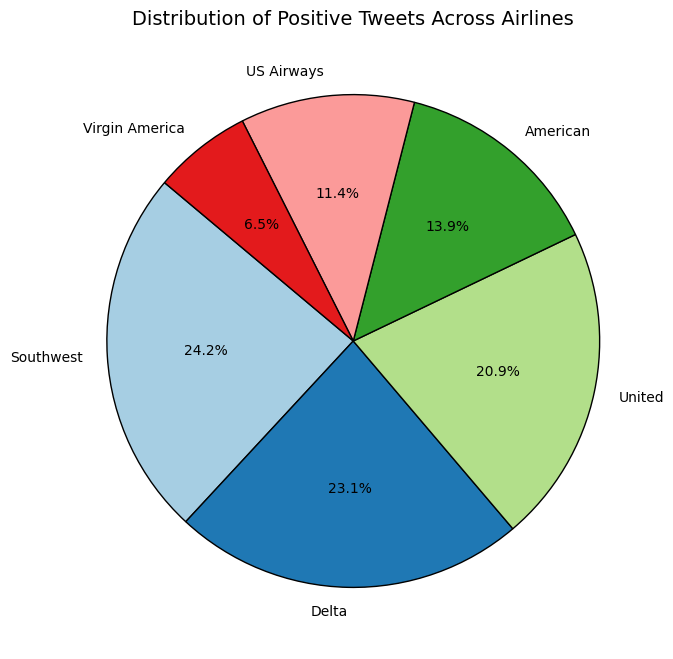

<ipython-input-541-6531af0b603e>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


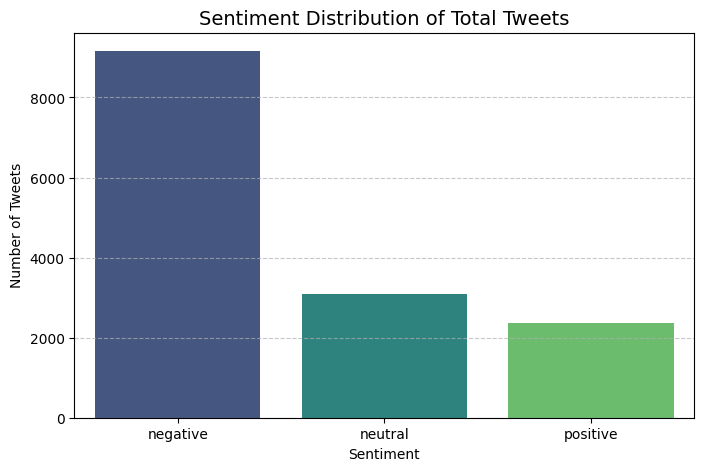

<Figure size 1200x600 with 0 Axes>

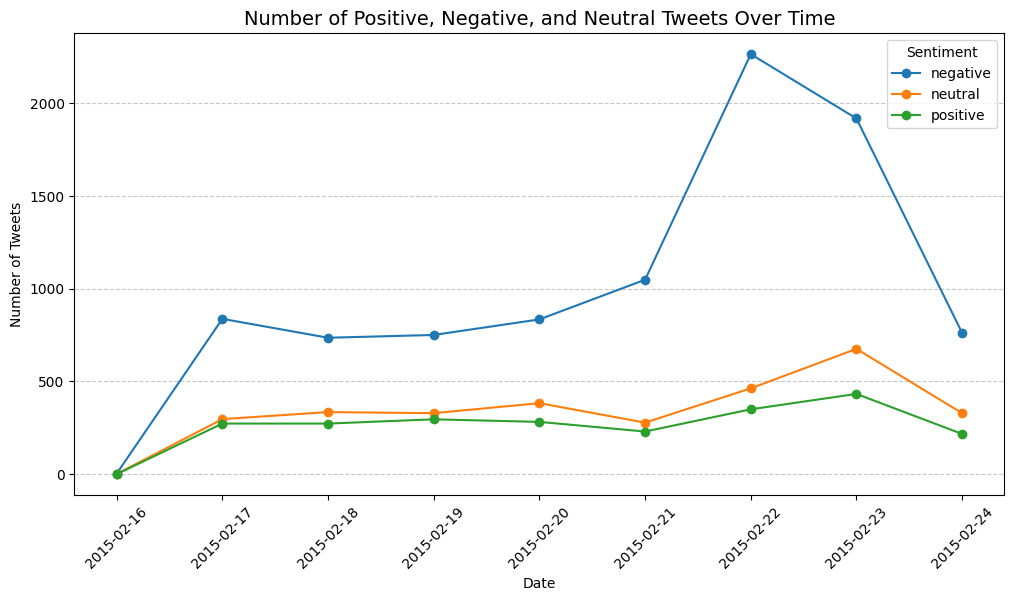

In [ ]:
### ADD YOUR CODE HERE ###

positive_tweets = df_cleaned[df_cleaned['airline_sentiment'] == 'positive']

# Count the number of positive tweets per airline
positive_counts = positive_tweets['airline'].value_counts()

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(positive_counts, labels=positive_counts.index, autopct='%1.1f%%', startangle=140,
        wedgeprops={'edgecolor': 'black'}, colors=plt.cm.Paired.colors)
plt.title("Distribution of Positive Tweets Across Airlines", fontsize=14)
plt.show()

# Count the number of tweets for each sentiment category
sentiment_counts = df_cleaned['airline_sentiment'].value_counts()

# Plot bar graph
plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
plt.title("Sentiment Distribution of Total Tweets", fontsize=14)
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

# Convert tweet_created column to datetime format
df_cleaned['tweet_created'] = pd.to_datetime(df_cleaned['tweet_created'])

# Extract date (ignoring time) for grouping
df_cleaned['tweet_date'] = df_cleaned['tweet_created'].dt.date

# Group by date and sentiment to get the count of each sentiment per day
sentiment_over_time = df_cleaned.groupby(['tweet_date', 'airline_sentiment']).size().unstack(fill_value=0)

# Plot the sentiment trend over time
plt.figure(figsize=(12, 6))
sentiment_over_time.plot(kind='line', marker='o', figsize=(12, 6))
plt.title("Number of Positive, Negative, and Neutral Tweets Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()



7. Data preparation

Remove unncessary columns and rows with sentiment confidence less than 50%

In [ ]:

low_confidence_rows = df_cleaned[df_cleaned['airline_sentiment_confidence'] < 0.5]
df_final = df_cleaned[df_cleaned['airline_sentiment_confidence'] >= 0.5]
#print(low_confidence_rows)
#df_final.info()
df_expanded = df_final.copy()

rows_to_duplicate = df_expanded[df_expanded['retweet_count'] > 0]

duplicated_rows = rows_to_duplicate.loc[rows_to_duplicate.index.repeat(rows_to_duplicate['retweet_count'])]

df_expanded.loc[df_expanded['retweet_count'] > 0, 'retweet_count'] = 0

duplicated_rows['retweet_count'] = 0
df_expanded = pd.concat([df_expanded, duplicated_rows], ignore_index=True)

df_final = df_cleaned[['text', 'airline_sentiment']]
df_final.head(100)

text airline_sentiment
0                 @VirginAmerica What @dhepburn said.           neutral
1   @VirginAmerica plus you've added commercials t...          positive
2   @VirginAmerica I didn't today... Must mean I n...           neutral
3   @VirginAmerica it's really aggressive to blast...          negative
4   @VirginAmerica and it's a really big bad thing...          negative
..                                                ...               ...
95  @VirginAmerica Is it me, or is your website do...          negative
96  @VirginAmerica I can't check in or add a bag. ...          negative
97  @VirginAmerica - Let 2 scanned in passengers l...          negative
98  @virginamerica What is your phone number. I ca...          negative
99  @VirginAmerica is anyone doing anything there ...          negative

[100 rows x 2 columns]

In [ ]:
### ADD YOUR CODE HERE ###
nltk.download('punkt')
nltk.download('punkt_tab')
nltk_tokenizer = word_tokenize
torchtext_tokenizer = get_tokenizer("basic_english")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
def tokenize_and_time(df, tokenizer, tokenizer_name):
    start_time = time.time()
    tokenized_texts = [tokenizer(text) for text in df['text']]
    end_time = time.time()
    vocab_size = len(set(word for tokens in tokenized_texts for word in tokens))
    return tokenized_texts, vocab_size, end_time - start_time

def yield_tokens(tokenized_texts):
    for text in tokenized_texts:
        yield text

In [ ]:
import torchtext
import torch
print(torch.__version__)
print(torchtext.__version__)

2.0.0+cu117
0.15.1+cpu


In [ ]:
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

# Define tokenizer (basic English tokenizer from TorchText)
tokenizer = get_tokenizer("basic_english")

# Function to yield tokens from tokenized text
def yield_tokens(tokenized_texts):
    for text in tokenized_texts:
        yield text

# Define special tokens
special_tokens = ["<unk>", "<pad>"]
torchtext_tokens = [tokenizer(text) for text in df_final["text"]]
# Build vocabulary from training data, including special tokens
vocab = build_vocab_from_iterator(yield_tokens(torchtext_tokens), specials=special_tokens)

# Set default index for unknown tokens
vocab.set_default_index(vocab["<unk>"])  # Ensures unknown tokens don’t cause an error

# Convert text to numerical sequences
numerical_sequences = [[vocab[token] for token in tokens] for tokens in torchtext_tokens]

# Compute max sequence length based on 95th percentile
seq_lengths = [len(seq) for seq in numerical_sequences]
max_length = int(torch.quantile(torch.tensor(seq_lengths, dtype=torch.float32), 0.95))

# Ensure <pad> token exists
if "<pad>" not in vocab:
    print(" Error: <pad> token not found in vocabulary!")

# Pad sequences properly
padded_sequences = torch.nn.utils.rnn.pad_sequence(
    [torch.tensor(seq[:max_length] + [vocab["<pad>"]] * max(0, max_length - len(seq))) for seq in numerical_sequences],
    batch_first=True
)

# Print vocabulary size and max sequence length
{
    "Chosen Tokenizer": "TorchText (basic_english)",
    "Vocabulary Size": len(vocab),
    "Max Sequence Length": max_length
}


{'Chosen Tokenizer': 'TorchText (basic_english)',
 'Vocabulary Size': 17385,
 'Max Sequence Length': 32}

8. Split dataset into train, validation, and test sets

In [ ]:
### ADD YOUR CODE HERE ###
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

train_df, temp_df = train_test_split(df_final, test_size=0.30, random_state=42, stratify=df_final['airline_sentiment'])
val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=42, stratify=temp_df['airline_sentiment'])


split_counts = {
    "Train Set": len(train_df),
    "Validation Set": len(val_df),
    "Test Set": len(test_df)
}

split_counts


{'Train Set': 10222, 'Validation Set': 2191, 'Test Set': 2191}

In [ ]:
train_tokens = [torchtext_tokenizer(text) for text in train_df['text']]
val_tokens = [torchtext_tokenizer(text) for text in val_df['text']]
test_tokens = [torchtext_tokenizer(text) for text in test_df['text']]

In [ ]:
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
train_labels = [sentiment_mapping[label] for label in train_df['airline_sentiment']]
val_labels = [sentiment_mapping[label] for label in val_df['airline_sentiment']]
test_labels = [sentiment_mapping[label] for label in test_df['airline_sentiment']]


In [ ]:
train_sequences = [[vocab[token] for token in tokens] for tokens in train_tokens]
val_sequences = [[vocab[token] for token in tokens] for tokens in val_tokens]
test_sequences = [[vocab[token] for token in tokens] for tokens in test_tokens]

In [ ]:
padded_train = torch.nn.utils.rnn.pad_sequence(
    [torch.tensor(seq[:max_length] + [vocab["<pad>"]] * (max_length - len(seq))) for seq in train_sequences],
    batch_first=True
)

padded_val = torch.nn.utils.rnn.pad_sequence(
    [torch.tensor(seq[:max_length] + [vocab["<pad>"]] * (max_length - len(seq))) for seq in val_sequences],
    batch_first=True
)

padded_test = torch.nn.utils.rnn.pad_sequence(
    [torch.tensor(seq[:max_length] + [vocab["<pad>"]] * (max_length - len(seq))) for seq in test_sequences],
    batch_first=True
)

In [ ]:
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)


padded_train_tensor = torch.tensor(padded_train, dtype=torch.long)
padded_val_tensor = torch.tensor(padded_val, dtype=torch.long)
padded_test_tensor = torch.tensor(padded_test, dtype=torch.long)


train_dataset = TensorDataset(padded_train_tensor, train_labels_tensor)
val_dataset = TensorDataset(padded_val_tensor, val_labels_tensor)
test_dataset = TensorDataset(padded_test_tensor, test_labels_tensor)


<ipython-input-552-94bd3ef8a636>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_train_tensor = torch.tensor(padded_train, dtype=torch.long)
<ipython-input-552-94bd3ef8a636>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_val_tensor = torch.tensor(padded_val, dtype=torch.long)
<ipython-input-552-94bd3ef8a636>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_test_tensor = torch.tensor(padded_test, dtype=torch.long)


## Step 2: Baseline LSTM Model

1. Build an LSTM model

In [ ]:
### ADD YOUR CODE HERE ###
class BaseLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout):
        super(BaseLSTM, self).__init__()


        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=vocab["<pad>"])

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)

        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)  # Hidden FC layer
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)  # Output layer

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        last_hidden_state = lstm_out[:, -1, :]

        # Fully connected layers
        x = self.fc1(last_hidden_state)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return self.softmax(x)

In [ ]:
import pandas as pd
print(train_df['airline_sentiment'].value_counts(normalize=True))
print(val_df['airline_sentiment'].value_counts(normalize=True))


airline_sentiment
negative    0.627177
neutral     0.211602
positive    0.161221
Name: proportion, dtype: float64
airline_sentiment
negative    0.627111
neutral     0.211775
positive    0.161114
Name: proportion, dtype: float64


2. Train your model

In [ ]:
def train_model(device,model, batch_num, num_epochs, optimizer, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_loader = DataLoader(train_dataset, batch_size=batch_num, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_num, shuffle=False)

    train_losses, val_losses = {}, {}
    train_accuracies, val_accuracies = {}, {}
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        total_loss, correct, total = 0, 0, 0
        all_train_preds, all_train_labels = [], []

        for batch in train_loader:
            texts, labels = batch
            texts, labels = texts.to(device), labels.to(device)

            optimizer.zero_grad()
            predictions = model(texts)
            loss = criterion(predictions, labels)
            if torch.isnan(loss).any():
              print(" NaN detected! Stopping training.")
              break

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(predictions, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_train_preds.extend(predicted.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

        train_loss = total_loss / len(train_loader)
        train_accuracy = correct / total

        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
            all_train_labels, all_train_preds, average='weighted', zero_division=0)

        val_loss, val_accuracy, val_precision, val_recall, val_f1 = evaluate(model, val_loader, criterion)

        end_time = time.time()
        epoch_time = end_time - start_time

        print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_time:.2f}s")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2%}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}")

        print(f"Train Precision: {train_precision:.2%}, Train Recall: {train_recall:.2%}, Train F1 Score: {train_f1:.2%}")
        print(f"Validation Precision: {val_precision:.2%}, Validation Recall: {val_recall:.2%}, Validation F1 Score: {val_f1:.2%}\n")

        train_losses[epoch+1]=train_loss
        val_losses[epoch+1]=val_loss
        train_accuracies[epoch+1]=train_accuracy
        val_accuracies[epoch+1]=val_accuracy

    return model,train_losses, val_losses, train_accuracies, val_accuracies


def evaluate(model, loader, criterion):


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in loader:
            texts, labels = batch
            texts, labels = texts.to(device), labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = correct / total

    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0)

    return avg_loss, accuracy, precision, recall, f1

In [ ]:
import numpy as np
print("NumPy Version:", np.__version__)

NumPy Version: 1.26.4


In [ ]:
model = BaseLSTM(vocab_size=len(vocab), embedding_dim=100, hidden_dim=128, output_dim=3, num_layers=3, dropout=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  #
model.to(device)

class_counts = torch.tensor([0.627177, 0.211602, 0.161221])
weights = 1.0 / class_counts
weights = weights / weights.sum()
weights = weights.to(torch.float32).to(device)


criterion = nn.CrossEntropyLoss(weight=weights)

print("Unique labels in training set:", set(train_labels))
print("Unique labels in validation set:", set(val_labels))
print("Unique labels in test set:", set(test_labels))

trained_model,train_losses, val_losses, train_accuracies, val_accuracies = train_model(device,model, batch_num=32, num_epochs=15, optimizer=optimizer, criterion=criterion)


Unique labels in training set: {0, 1, 2}
Unique labels in validation set: {0, 1, 2}
Unique labels in test set: {0, 1, 2}
Epoch 1/15 | Time: 1.58s
Train Loss: 1.0822, Train Accuracy: 39.15%
Validation Loss: 1.0342, Validation Accuracy: 55.27%
Train Precision: 55.24%, Train Recall: 39.15%, Train F1 Score: 41.78%
Validation Precision: 75.03%, Validation Recall: 55.27%, Validation F1 Score: 52.80%

Epoch 2/15 | Time: 1.48s
Train Loss: 1.0179, Train Accuracy: 56.67%
Validation Loss: 1.0128, Validation Accuracy: 64.49%
Train Precision: 60.25%, Train Recall: 56.67%, Train F1 Score: 55.04%
Validation Precision: 60.32%, Validation Recall: 64.49%, Validation F1 Score: 59.92%

Epoch 3/15 | Time: 1.45s
Train Loss: 0.9801, Train Accuracy: 63.55%
Validation Loss: 0.9787, Validation Accuracy: 56.00%
Train Precision: 64.29%, Train Recall: 63.55%, Train F1 Score: 63.25%
Validation Precision: 66.41%, Validation Recall: 56.00%, Validation F1 Score: 58.39%

Epoch 4/15 | Time: 1.47s
Train Loss: 0.9352, Tra

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
test_loss, test_accuracy, test_precision, test_recall, test_f1 = evaluate(trained_model, test_loader, criterion)
print(f"Test Accuracy: {test_accuracy:.2%}, Test Precision: {test_precision:.2%}, Test Recall: {test_recall:.2%}, Test F1 Score: {test_f1:.2%}")

Test Accuracy: 71.70%, Test Precision: 73.01%, Test Recall: 71.70%, Test F1 Score: 72.21%


Epochs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Train Acc: [0.39150851105458817, 0.5667188417139503, 0.6354920759146938, 0.6639600860888281, 0.6833300723928781, 0.707102328311485, 0.7016239483467032, 0.7176677753864215, 0.724907063197026, 0.7123850518489533, 0.7176677753864215, 0.737331246331442, 0.7413422030913716, 0.7502445705341421, 0.751907650166308]
Val Acc: [0.5527156549520766, 0.6449109995435874, 0.5600182565038795, 0.6184390689183021, 0.6481058877225011, 0.6805111821086262, 0.6964856230031949, 0.7097215883158375, 0.6791419443176632, 0.700593336376084, 0.7124600638977636, 0.6960292104062072, 0.6773162939297125, 0.7106344135098128, 0.7311729803742584]


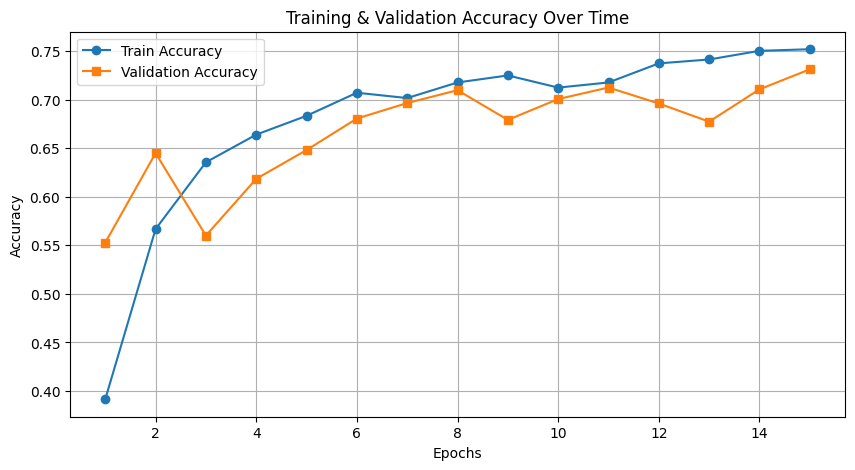

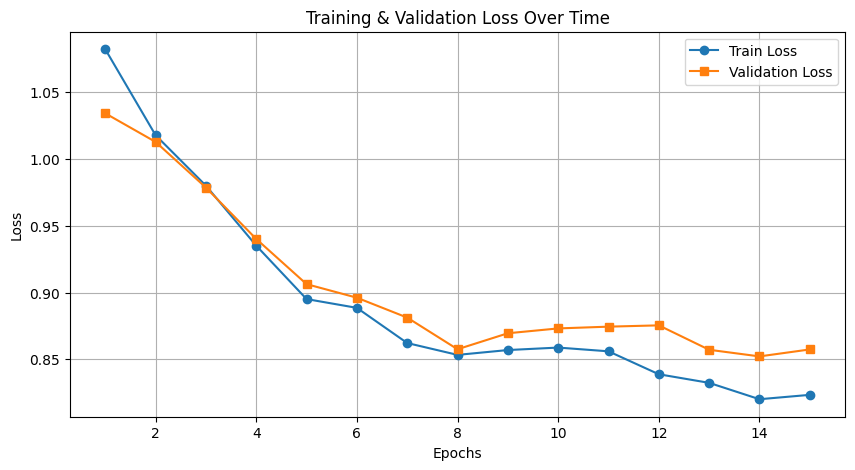

In [ ]:
# Extract values from dictionary (sorted by epoch keys)
epochs = sorted(train_accuracies.keys())  # Ensure correct order
train_acc_values = [train_accuracies[e] for e in epochs]
val_acc_values = [val_accuracies[e] for e in epochs]

train_loss_values = [train_losses[e] for e in epochs]
val_loss_values = [val_losses[e] for e in epochs]

# Print values for debugging
print("Epochs:", epochs)
print("Train Acc:", train_acc_values)
print("Val Acc:", val_acc_values)

# Plot Training & Validation Accuracy Over Time
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc_values, label="Train Accuracy", marker='o')
plt.plot(epochs, val_acc_values, label="Validation Accuracy", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Plot Training & Validation Loss Over Time
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_values, label="Train Loss", marker='o')
plt.plot(epochs, val_loss_values, label="Validation Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()


<span style='color:green'>### YOUR ANSWER ###</span>

3. Evaluation and analysis

Test Loss: 0.8748
Test Accuracy: 71.70%
Test Precision: 73.01%
Test Recall: 71.70%
Test F1 Score: 72.21%



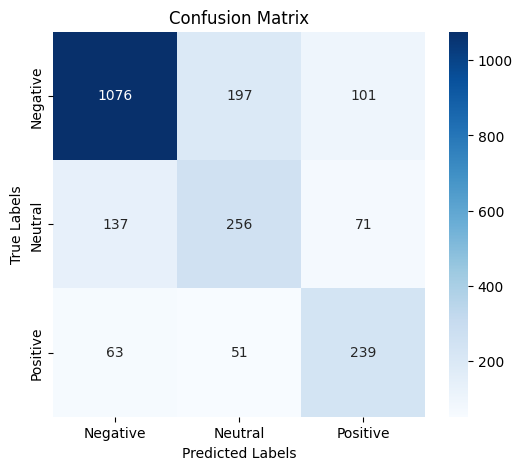

Classification Report:
               precision    recall  f1-score   support

    Negative       0.84      0.78      0.81      1374
     Neutral       0.51      0.55      0.53       464
    Positive       0.58      0.68      0.63       353

    accuracy                           0.72      2191
   macro avg       0.64      0.67      0.66      2191
weighted avg       0.73      0.72      0.72      2191



In [ ]:
### ADD YOUR CODE HERE ###

# Print evaluation metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2%}")
print(f"Test Precision: {test_precision:.2%}")
print(f"Test Recall: {test_recall:.2%}")
print(f"Test F1 Score: {test_f1:.2%}\n")

# Get true labels and predictions for confusion matrix
true_labels = []
predicted_labels = []

with torch.no_grad():
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        outputs = trained_model(texts)
        _, preds = torch.max(outputs, dim=1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(true_labels, predicted_labels, target_names=["Negative", "Neutral", "Positive"]))


<span style='color:green'>### YOUR ANSWER ###</span>

4. Save the weights of the trained neural network

In [ ]:
### ADD YOUR CODE HERE ###
model_save_path = "best_lstm_model.pt"
torch.save(trained_model.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")

Model weights saved to best_lstm_model.pt


## Step 3: Improved LSTM Model

1. Improve your baseline LSTM model

In [ ]:


class ImprovedLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout, embedding_matrix=None):
        super(ImprovedLSTM, self).__init__()

        if embedding_matrix is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)  # Allow fine-tuning
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=vocab["<pad>"])

        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)

        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
      embedded = self.embedding(x)
      gru_out, _ = self.gru(embedded)

      attention_weights = torch.tanh(self.attention(gru_out))
      attention_weights = torch.softmax(attention_weights, dim=1)

      context_vector = torch.sum(gru_out * attention_weights, dim=1)
     # context_vector = self.batch_norm(context_vector)

      # print(f"Shape before fc1: {context_vector.shape}")  # Debugging shape

      # Fully Connected Layers
      x = self.fc1(context_vector)
    #  print(f"Shape after fc1: {x.shape}")  # Debugging shape

      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)

      return self.softmax(x)



2. Create a new class for your improved model

In [ ]:
import numpy as np

embedding_dim = 100

embeddings_index = {}
with open("glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(vocab), embedding_dim))
for word, idx in vocab.get_stoi().items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector
    else:
        # For words not found in GloVe, initialize them with a normal distribution
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))


embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)



In [ ]:
model2 = ImprovedLSTM(vocab_size=len(vocab), embedding_dim=100, hidden_dim=128, output_dim=3, num_layers=3, dropout=0.2,embedding_matrix=embedding_matrix) # vocab_size should match the actual size


3. Follow the same training and evaluation procedures

In [ ]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.Adam(model2.parameters(), lr=0.0001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Calculate class counts from the training labels
class_counts = torch.tensor(train_df['airline_sentiment'].value_counts().values, device=device, dtype=torch.float32)
weights2 = 1.0 / class_counts
weights2 = weights2 / weights2.sum()
print(weights2)

criterion = nn.CrossEntropyLoss(weight=weights2)

trained_model2,train_losses2, val_losses2, train_accuracies2, val_accuracies2 = train_model(device,model2, batch_num=32, num_epochs=15, optimizer=optimizer, criterion=criterion)


tensor([0.1273, 0.3774, 0.4953], device='cuda:0')
Epoch 1/15 | Time: 2.14s
Train Loss: 1.0341, Train Accuracy: 58.78%
Validation Loss: 0.9673, Validation Accuracy: 63.99%
Train Precision: 60.24%, Train Recall: 58.78%, Train F1 Score: 58.37%
Validation Precision: 65.90%, Validation Recall: 63.99%, Validation F1 Score: 61.91%

Epoch 2/15 | Time: 1.95s
Train Loss: 0.9328, Train Accuracy: 66.97%
Validation Loss: 0.8829, Validation Accuracy: 70.56%
Train Precision: 68.59%, Train Recall: 66.97%, Train F1 Score: 67.24%
Validation Precision: 73.20%, Validation Recall: 70.56%, Validation F1 Score: 71.57%

Epoch 3/15 | Time: 1.98s
Train Loss: 0.8836, Train Accuracy: 69.40%
Validation Loss: 0.8701, Validation Accuracy: 69.06%
Train Precision: 72.05%, Train Recall: 69.40%, Train F1 Score: 70.33%
Validation Precision: 72.80%, Validation Recall: 69.06%, Validation F1 Score: 69.93%

Epoch 4/15 | Time: 1.97s
Train Loss: 0.8503, Train Accuracy: 71.70%
Validation Loss: 0.8401, Validation Accuracy: 74.62

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
test_loss2, test_accuracy2, test_precision2, test_recall2, test_f12 = evaluate(trained_model2, test_loader, criterion)
print(f"Test Accuracy: {test_accuracy2:.2%}, Test Precision: {test_precision2:.2%}, Test Recall: {test_recall2:.2%}, Test F1 Score: {test_f12:.2%}")

Test Accuracy: 76.54%, Test Precision: 76.71%, Test Recall: 76.54%, Test F1 Score: 76.57%


4. Directly compare the performance of your improved model to the baseline model

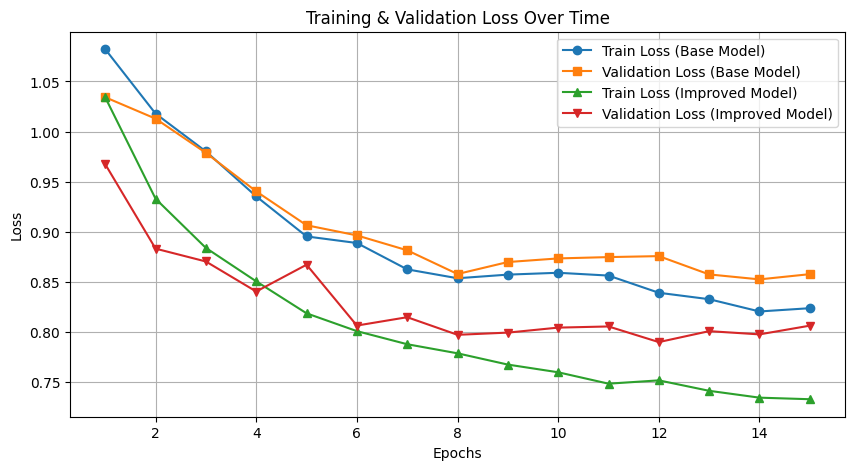

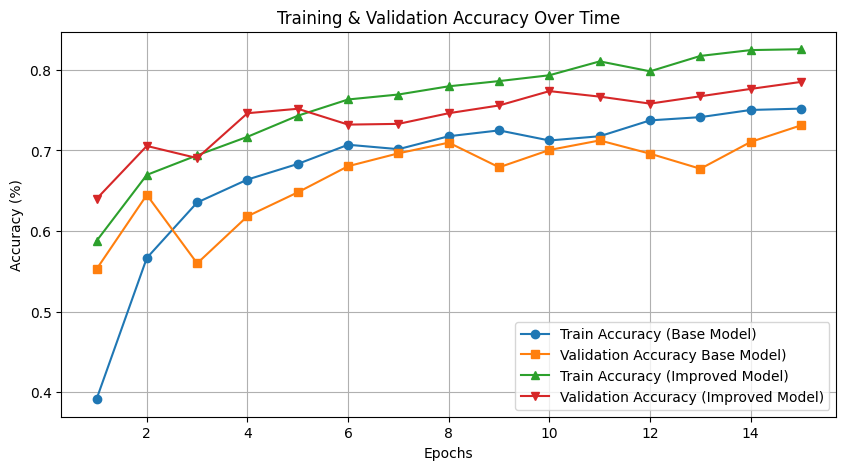

In [ ]:
### ADD YOUR CODE HERE ###


epochs = sorted(train_losses.keys())

train_loss_values = [train_losses[e] for e in epochs]
val_loss_values = [val_losses[e] for e in epochs]
train_loss2_values = [train_losses2[e] for e in epochs]
val_loss2_values = [val_losses2[e] for e in epochs]

train_acc_values = [train_accuracies[e] for e in epochs]
val_acc_values = [val_accuracies[e] for e in epochs]
train_acc2_values = [train_accuracies2[e] for e in epochs]
val_acc2_values = [val_accuracies2[e] for e in epochs]

# Plot Training & Validation Loss for Both Models
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_values, label="Train Loss (Base Model)", marker='o')
plt.plot(epochs, val_loss_values, label="Validation Loss (Base Model)", marker='s')
plt.plot(epochs, train_loss2_values, label="Train Loss (Improved Model)", marker='^')
plt.plot(epochs, val_loss2_values, label="Validation Loss (Improved Model)", marker='v')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()

# Plot Training & Validation Accuracy for Both Models
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc_values, label="Train Accuracy (Base Model)", marker='o')
plt.plot(epochs, val_acc_values, label="Validation Accuracy Base Model)", marker='s')
plt.plot(epochs, train_acc2_values, label="Train Accuracy (Improved Model)", marker='^')
plt.plot(epochs, val_acc2_values, label="Validation Accuracy (Improved Model)", marker='v')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy Over Time")
plt.legend()
plt.grid(True)
plt.show()


<span style='color:green'>### YOUR ANSWER ###</span>

5. Save the weights of the trained neural network

In [ ]:
### ADD YOUR CODE HERE ###
### ADD YOUR CODE HERE ###
model_save_path2 = "best_lstm__improved_model2.pt"
torch.save(trained_model2.state_dict(), model_save_path2)
print(f"Model weights saved to {model_save_path2}")

Model weights saved to best_lstm__improved_model2.pt


## Step 4: Discussion

1. Briefly describe the dataset and its key characteristics



<span style='color:green'>### YOUR ANSWER ###</span>

2. Describe both your baseline and improved LSTM architectures in detail

<span style='color:green'>### YOUR ANSWER ###</span>



The dataset is a csv file that give us  sentiment analysis about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets. Some of the main columns are described below

**tweet_id** - Numerical unique ID for every tweet


**airline_sentiment** - sentiment label assigned to the tweet in the row (Posive,negative or neutral)

**text** - The text of the tweet which we tokenize and use to train our model

**airline_sentiment_confidence**- a value between 0 and 1 that tells us the confidence assigned to this label

**airline** - Name of the airline pertaining to this particular row


In [ ]:
import torch
from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define your models with appropriate values
baseline_model = BaseLSTM(vocab_size=len(vocab), embedding_dim=100, hidden_dim=128, output_dim=3, num_layers=3, dropout=0.3)
improved_model = ImprovedLSTM(vocab_size=len(vocab), embedding_dim=100, hidden_dim=128, output_dim=3, num_layers=3, dropout=0.2, embedding_matrix=embedding_matrix)

# Move the models to the same device as your input
baseline_model = baseline_model.to(device)
improved_model = improved_model.to(device)

batch_size = 32
seq_length = max_length  # make sure max_length is defined
input_data = torch.randint(0, len(vocab), (batch_size, seq_length), dtype=torch.long).to(device)

print("Baseline LSTM Model Summary:")
baseline_summary = summary(baseline_model, input_data=input_data, col_names=["input_size", "output_size", "num_params", "trainable"])
print(baseline_summary)

print("\nImproved LSTM Model Summary:")
improved_summary = summary(improved_model, input_data=input_data, col_names=["input_size", "output_size", "num_params", "trainable"])
print(improved_summary)


Baseline LSTM Model Summary:
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
BaseLSTM                                 [32, 32]                  [32, 3]                   --                        True
├─Embedding: 1-1                         [32, 32]                  [32, 32, 100]             1,738,500                 True
├─LSTM: 1-2                              [32, 32, 100]             [32, 32, 128]             381,952                   True
├─Linear: 1-3                            [32, 128]                 [32, 64]                  8,256                     True
├─ReLU: 1-4                              [32, 64]                  [32, 64]                  --                        --
├─Dropout: 1-5                           [32, 64]                  [32, 64]                  --                        --
├─Linear: 1-6                            [32, 64]                  [32, 3]                   195      

The architectures of both models are displayed above the improvements made as described below



1.Base model uses a unidirectional LSTM, the improved model employs a bidirectional GRU. This change allows the model to capture context from both past and future tokens, which can be especially beneficial in understanding the nuances of text.

2.The improved model computes a weighted sum of all GRU outputs using an attention mechanism. This lets the network focus on the most informative parts of the sequence rather than relying on a single fixed representation.

3.The improved model  initialized its embedding layer with pretrained vectors (glove), which provides a richer semantic representation of words.

3.The improved model also adjusts dropout rates and the number of layers to optimize learning.





3. Discuss the results, comparing the performance of the baseline and improved models



<span style='color:green'>### YOUR ANSWER ###</span>

From the plots we know
it’s clear that the Improved model is better than base model both in loss and accuracy metrics:

 Improved model consistently outperforms the baseline , we can see lower training and validation losses as well as higher training and validation accuracies. The loss curve of base model ends up higher than that of improved model

 Similarly, the improved model’s accuracy steadily climbs, surpassing the baseline’s final accuracy by several percentage points.The improved model does not show signs of severe overfitting, as both training and validation performance continue to improve rather than diverge.

 These findings indicate that the enhancements—be they architectural changes, hyperparameter tuning, or other adjustments—successfully boosted both learning efficiency and generalization capability over the baseline approach.

4. Discuss the strengths and limitations of using recurrent neural models for sentiment analysis

<span style='color:green'>### YOUR ANSWER ###</span>



1.   Handling Long Sequences

     **Strength**

     LSTMs are designed to manage long-term dependencies, making them effective in processing long texts where sentiment may depend on context spread across the sequence

    **Weakness**

     LSTMs can still face challenges with very long sequences, potentially leading to training instability and difficulty in capturing dependencies over extended texts

1.   Computational cost

      **Strength**

      LSTMs can learn complex patterns in data

    **Weakness**

    Training and deploying LSTMs can be computationally intensive with large datasets or long sequences, leading to increased processing times and resource requirements.

3.   Sensitivity to Hyperparameters

     **Strength**

      Proper tuning of hyperparameters can significantly enhance LSTM performance, allowing customization for specific datasets and tasks.

    **Weakness**

      Improper tuning can lead to suboptimal performance or overfitting, necessitating extensive experimentation to identify optimal configurations.



4.   Interpretability Compared to Simpler Models


  **Strength**

   LSTMs can model intricate relationships in data, potentially capturing subtle sentiment cues that simpler models might miss.

  **Weakness**

  complexity of LSTMs makes them less interpretable than models like logistic regression, making it challenging to understand the decision-making process and feature importance




5. References. Include details on all the resources used to complete this part.




<span style='color:green'>### YOUR ANSWER ###</span>

[Pytorch LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)

[Airline sentiment Dataset ](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment)

[Neural network functioning](https://discuss.boardinfinity.com/t/what-are-the-advantages-and-disadvantages-of-neural-networks/433/2)

[Bright data Sentiment Analysis](https://brightdata.com/blog/web-data/sentiment-analysis-explained)

[Medium Sentiment analysis LSTM](https://medium.com/%40anishnama20/understanding-lstm-architecture-pros-and-cons-and-implementation-3e0cca194094)

[Drawback of LSTMS paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=5080605)

[Nature article LSTM](https://www.nature.com/articles/s41598-025-88378-6)